# Rapport du projet annuel

## Auteur
- BENDAVID Natane
- TARDY Louis
- WADE Cheikh Abdourahmane

## Problématique 

Problématiques applicatives : Classification d'images de vêtement, 3 Types :
- Chaussures
- Haut
- Pantalons

## Descriptif du rapport
Le but de ce rapport est de présenter l’étude des performances de tous les algorithmes et modèles implementés lors de ce projet. 

Nous metterons en évidence l'impact des différents paramètres des algorithmes étudiés sur la rapidité de convergence de ceux-ci.

Dans ce rapport nous mettront en évidence 4 algorithmes de machine learning :

- Modèle linéaire
- Perceptron Multi Couches
- Radial Basis Function Network
- SVM 

L’ensemble de ces modèles et algorithmes sont implémentés en rust (convertie en lib C) de manière à pouvoir être
aisément utilisé comme une bibliothèque dynamique manipulée depuis des scripts python

Nous étudierons plusieurs cas de test par algorithme implémenté pour démontrer sont n'efficacité ou non selon le problème

Nous étudierons des cas de classifications et de régressions

## Import de la lib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ctypes import *

my_dll_path = "C:/Users/MOI/dev/PA-MachineLearning-3ESGI/Project/Lib/MachineLearning/target/debug/machine_learning_c.dll"
my_lib = CDLL(my_dll_path)

## Modèle linéaire

Pour implémenter l'algorithme de modelé linéaire nous avons suivie un workflow spécifique pour préparer, entraîner et exploiter les données en sortie :

1) Crétion d'un modèle :
- Création d'un modèle aléatoire de base, avec des valeurs comprises entre -1 et 1 

2) Entrainement du modèle:
- Pour la classification : Entrainement du modèle avec la règle de Rosenblatt
- Pour la régression : Entrainement du modèle avec la pseudo inverse

3) Prédiction des résultats

4) Test du modèle

### Paramétrage de la lib

In [2]:
# Création d'un model
my_lib.create_linear_model.restype = c_void_p
my_lib.create_linear_model.argtypes = [c_int]
# Prédiction d'un model pour la classification
my_lib.predict_linear_classification.argtypes = [
    c_void_p,
    POINTER(c_double),
    c_int
]
my_lib.predict_linear_classification.restype = c_double
# Prédiction d'un model pour la régression
my_lib.predict_linear_regression.argtypes = [
    c_void_p,
    POINTER(c_double),
    c_int
]
my_lib.predict_linear_regression.restype = c_double
# Entrainement du model pour la classification
my_lib.train_linear_model_classification_python.argtypes = [
    c_void_p,
    POINTER(c_double),
    POINTER(c_double),
    c_int,
    c_int,
    c_int,
    c_double
]
my_lib.train_linear_model_classification_python.restype = None
# Entrainement du model pour la regression
my_lib.train_linear_model_regression_python.argtypes = [
    c_void_p,
    POINTER(c_double),
    POINTER(c_double),
    c_int,
    c_int
]
my_lib.train_linear_model_regression_python.restype = None

### Classification

### Cas d'un test simple
Nous commençons à tester notre modèle sur un cas de test assez simple. 

Le but est de séparer deux points pour pouvoir les classer.

After Training
1.0
-1.0
-1.0


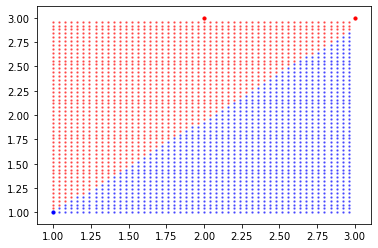

<Figure size 432x288 with 0 Axes>

In [20]:
# Data
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
], dtype='float64')
Y = np.array([
      1,
      -1,
      -1
], dtype='float64')
flattened_X = X.flatten()
#Création du model
model = my_lib.create_linear_model(c_int(X.shape[1]))

#Entrainement du model
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    Y.ctypes.data_as(POINTER(c_double)),
    X.shape[0],
    X.shape[1],
    1000,
    0.01
)

#Prediction du model
print("After Training")
for inputs_k in X:
    print(my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k)))


#Test du model
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    predicted_value = my_lib.predict_linear_classification(
                model,
                test_input_k.ctypes.data_as(POINTER(c_double)),
                len(test_input_k))
    if predicted_value == 1.0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X[0, 0], X[0, 1], color='blue', s=10)
plt.scatter(X[1:3, 0], X[1:3, 1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Grace à l'implémentation de la règle de ressemblante et au bon paramétrage du modèle (1000 tours de boucle est une epoch à 0.01) nous remarquons une bonne séparation entre le point bleu et les deux points rouge.

### Cas d'un test multi lineaire (Sur-entrainement)
Nous testons notre modèle sur un cas de test multi linéaire. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Test model Training


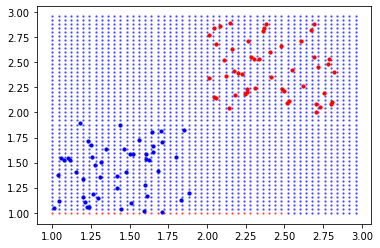

<Figure size 432x288 with 0 Axes>

In [9]:
X = np.concatenate([
    np.random.random((50,2)) * 0.9 + np.array([1, 1]),
    np.random.random((50,2)) * 0.9 + np.array([2, 2])],
    axis = 0)
Y = np.concatenate([np.ones((50, 2)), np.ones((50, 2)) * -1.0])
flattened_X = X.flatten()
#Création du model
model = my_lib.create_linear_model(c_int(X.shape[1]))

#Entrainement du model
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    Y.ctypes.data_as(POINTER(c_double)),
    X.shape[0],
    X.shape[1],
    10000000,
    0.0000001
)

#Test du model
print("Test model Training")
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    predicted_value = my_lib.predict_linear_classification(
                model,
                test_input_k.ctypes.data_as(POINTER(c_double)),
                len(test_input_k))
    if predicted_value == 1.0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)

plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', s=10)
plt.scatter(X[50:100,0], X[50:100,1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement, 10 millions de tours de boucle et une epoch de  0.0000001, nous avons un sur-entraînement du modèle. Nous constatons alors que nos résultats sont faussés dû au sur-entraînement du modèle.

### Cas d'un test simple (sous-entrainement)
Nous testons notre modèle sur un cas de test simple pour montrer le sou-entrainement du modèle dû à son mauvais paramétrage. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Nous avons repris ici le premier cas de test simpl:

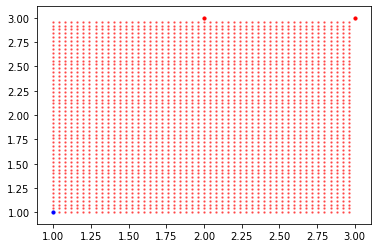

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement, 1 tour de boucle et une epoch de 0.01, nous avons un sous-entraînement du modèle. 
Nous constatons alors que nos résultats sont faussés dû au sous-entraînement du modèle.

### Conclusion classification modèle lineaire

Avec les différents tests que nous avons mis au point au-dessus, nous pouvons constater que le paramétrage du modèle joue un rôle crucial sur l'entraînement de celui-ci. 

En utilisant de grande valeur de paramétrage nous constatons un sur-entraînement du modèle, mais au contraire en utilisant de très petite valeur nous constatons un sous-entraînement du modèle. 

Le but est alors de trouver le bon paramétrage pour exploité au mieux l'entraînement. 